# Initialization

In [1]:
# Packages

import numpy as np               # for math formulas, random distribution and vectorization
import time                      # for time measurement
from scipy.stats import norm     # for Normal distribution CDF
import matplotlib.pyplot as plt  # for plots

In [2]:
# Data

S0 = 100.0   # Initial underlying asset price
K = 105.0    # Strike Price
r = 0.05     # Risk-free rate
sigma = 0.2  # Underlying asset Volatility
T = 1.0      # Time to maturity
steps = 100  # Number of steps per path
N = 1000   # Number of paths generated

# Explicit Solution for $C_0$  (BS Formula)

$$
C = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2)
$$

$$
\text{where} \quad
\begin{cases}
d_1 = \dfrac{\ln\left(\frac{S_0}{K}\right) + \left(r + \frac{\sigma^2}{2}\right) T}{\sigma \sqrt{T}} \\[8pt]
d_2 = d_1 - \sigma \sqrt{T} \\[8pt]
\Phi \text{ is the cumulative distribution function of } \mathcal{N}(0,1)
\end{cases}
$$

In [3]:
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f"Theoretical European Call Price (Black-Scholes) : {price:.5f}")

Theoretical European Call Price (Black-Scholes) : 8.02135


# 1st Method: Naive Python

**Euler-Maruyama Approximation:**
$$ 
S_{t+1} = S_t \exp\left( \left(r - \frac{\sigma^2}{2}\right) dt + \sigma \sqrt{dt} \, Z \right)
$$

$$
\text{where } dt = \frac{T}{n} \text{ and } \frac{dW_t}{\sqrt{dt}} = Z \sim \mathcal{N}(0, 1)
$$

In [4]:
def bs_simulation_naive():
    '''
    Function computing a single Monte Carlo Simulation with N paths,
    using naive python, involving two nested loops.
    '''
    payoffs = np.zeros(N)
    dt = T/steps

    # Not computing the drift and diffusion for every simulation divided the calculation time by 2
    drift = (r-(sigma**2)/2)*dt
    diffusion = sigma*np.sqrt(dt)  # note: the normal variable is part of the diffusion too
    
    for i in range(N):  # one iteration per path
        St = S0  # starting price for each path
        for _ in range(steps):
            St = St* np.exp(drift + diffusion*np.random.normal(0.0, 1.0))  # using the Euler-Maruyama 
        payoffs[i] = max(St-K, 0)

    call_price = np.exp(-(r * T)) * (1/N) * np.sum(payoffs)  # Call price (Discounted average payoff at maturity date)

    return call_price

In [5]:
# Repeating 10 times the naive-simulation with N = 10^5

N = 10**5

start = time.time()

prices = []
for _ in range (10):
    prices.append(bs_simulation_naive())

end = time.time()

print(f'--- For N = 10^5 paths:'
      f'The price of the European Call Option is on average estimated to be {np.mean(prices):.4f}, with a standard deviation of {np.std(prices, ddof = 1):.4f}.',
      f'\n The average time for a simulation was {(end-start)/10:.3f} seconds.')

--- For N = 10^5 paths:The price of the European Call Option is on average estimated to be 8.0200, with a standard deviation of 0.0330. 
 The average time for a simulation was 34.874 seconds.


# 2nd Method: Numpy Vectorization

To optimize the program with vectorization, we use the **increment of log-prices** due to their additive characteristic. They are given by:
$$
\Delta\ln S = \left(r - \frac{\sigma^2}{2}\right) dt + \sigma \sqrt{dt} \, Z
$$

In [6]:
def bs_simulation_vect():
    '''
    Function computing a single Monte Carlo Simulation with N paths
    using numpy vectorization (based on C), not involving any for-loop.
    '''
    dt = T/steps
    Z = np.random.normal(0.0, 1.0, size=(N, steps))  # (N x steps)-size matrix of draws from the N(0,1) distribution
    drift = (r - 0.5 * sigma**2) * dt  # constant drift
    diffusion = sigma * np.sqrt(dt) * Z  # (N x steps)-size matrix of diffusions
    log_returns = drift + diffusion
    log_paths = np.cumsum(log_returns, axis=1)  # cumulative log-price paths along time steps (axis=1 : across columns)
    ST = S0*np.exp(log_paths[:,-1])  # we only keep the last price
    payoffs = np.maximum(ST-K,0)
    call_price = np.exp(-r*T) * np.mean(payoffs)
    return call_price



In [7]:
# Repeating 10 times the vectorized-simulation with various values of N

for j in range(5, 8):

    N = 10**j
    
    start = time.time()
    
    prices = []
    for _ in range (10):
        prices.append(bs_simulation_vect())
    
    end = time.time()
    
    print(f'--- For N = 10^{j} paths:'
          f'\n The price of the European Call Option is on average estimated to be {np.mean(prices):.4f}, with a standard deviation of {np.std(prices, ddof = 1):.4f}.',
          f'\n The average time for a simulation was {(end-start)/10:.3f} seconds.\n')

--- For N = 10^5 paths:
 The price of the European Call Option is on average estimated to be 8.0359, with a standard deviation of 0.0246. 
 The average time for a simulation was 0.441 seconds.

--- For N = 10^6 paths:
 The price of the European Call Option is on average estimated to be 8.0251, with a standard deviation of 0.0074. 
 The average time for a simulation was 4.766 seconds.

--- For N = 10^7 paths:
 The price of the European Call Option is on average estimated to be 8.0212, with a standard deviation of 0.0044. 
 The average time for a simulation was 69.919 seconds.



# Plotting simulation results

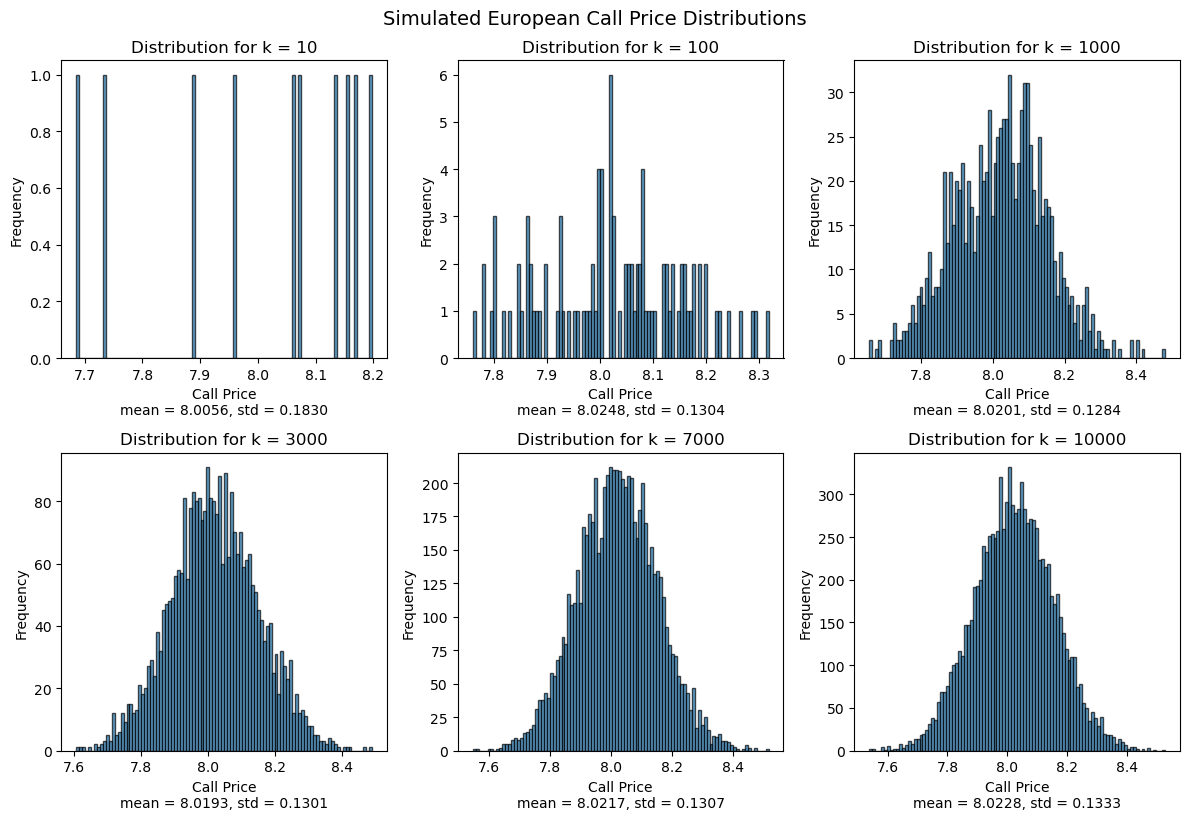

In [20]:
import matplotlib.pyplot as plt

N = 10000

ks = [10, 100, 1000, 3000, 7000, 10000]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # flatten to iterate easily

for i, k in enumerate(ks):
    prices = [bs_simulation_vect() for _ in range(k)]
    
    axes[i].hist(prices, bins=100, edgecolor='k', alpha=0.7)
    axes[i].set_title(f'Distribution for k = {k}')
    axes[i].set_xlabel(f'Call Price\nmean = {np.mean(prices):.4f}, std = {np.std(prices, ddof=1):.4f}')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(False)

plt.tight_layout()
plt.suptitle('Simulated European Call Price Distributions', fontsize=14, y=1.02)
plt.show()


By looking at the distribution of k simulations (with N = 10,000), we can consider that repeating k = 1,000 times the Monte Carlo simulation gives us a realistic estimation of the $\hat{C}_N$ estimator.